![schema](schema.png)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d as smooth

from disp import set_font_size


SEED = None
T_PRE = -20
T_POST = 20
T_DUR = 10
DT = 0.1
N_TR = 100

SMOOTH = int(.1/DT)
B_NOISE = .1 / np.sqrt(DT)
G_NOISE = 10 / np.sqrt(DT)

A_H_SCALE = .2
A_V_SCALE = .2

t = np.arange(T_PRE, T_POST, DT)
t_f = np.arange(-4, 4, DT)

o = ((0 <= t)&(t < 10)).astype(float)

Set context-specific parameters

In [2]:
# low-flow
h_o = -(t_f >= 0).astype(float)*np.exp(-t_f/.1)
v_o = (t_f >= 0).astype(float)*np.exp(-t_f/.1)

f_h = -.1*np.exp(-(t_f-1)**2/(2*.2**2))
w_h = -10

f_v = .1*(t_f >= 0).astype(float)*np.exp(-t_f/1.)
w_v = 0

f_o = .5*(t_f >= 0).astype(float)*np.exp(-t_f/1.)

In [3]:
# create samples
hs = np.nan * np.zeros((N_TR, len(t)))
vs = np.nan * np.zeros((N_TR, len(t)))
gs = np.nan * np.zeros((N_TR, len(t)))

h_odors = np.nan * np.zeros((N_TR, len(t)))
v_odors = np.nan * np.zeros((N_TR, len(t)))

np.random.seed(SEED)

for ctr in range(N_TR):
    # behav fluctuations
    h_fluc = smooth(B_NOISE*np.random.randn(len(t)), SMOOTH)
    v_fluc = smooth(B_NOISE*np.random.randn(len(t)), SMOOTH)
    
    # odor-trig behav
    a_h = A_H_SCALE * np.random.randn()
    a_v = A_V_SCALE * np.random.randn()
    
    h_odor = np.convolve(o, a_h*h_o, mode='same')
    v_odor = np.convolve(o, a_v*v_o, mode='same')
    
    h_odors[ctr] = h_odor
    v_odors[ctr] = v_odor
    
    # total behav
    h = h_fluc + h_odor
    v = v_fluc + v_odor
    
    hs[ctr] = h
    vs[ctr] = v
    
    # neural heading component
    g_h_fluc = np.convolve(h, f_h, mode='same')
    g_h_odor = w_h * h_odor
    
    # neural velocity component
    g_v_fluc = np.convolve(v, f_v, mode='same')
    g_v_odor = w_v * v_odor
    
    # neural odor component
    g_o = np.convolve(o, f_o, mode='same')
    
    # total neural
    g = .03*(g_h_fluc + g_h_odor + g_v_fluc + g_v_odor + g_o + smooth(G_NOISE*np.random.randn(len(t)), SMOOTH))
    gs[ctr] = g

Trial examples

H_ODOR WEIGHT = -10 ; V_ODOR WEIGHT = 0


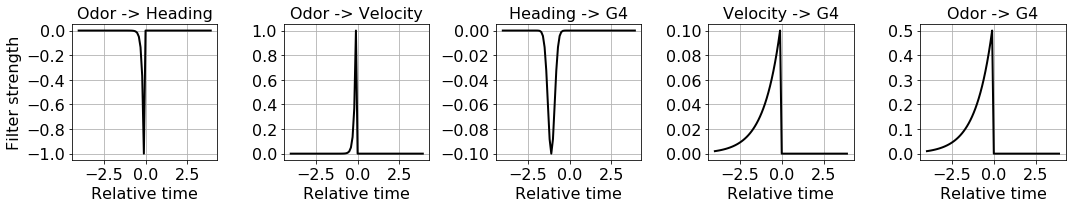

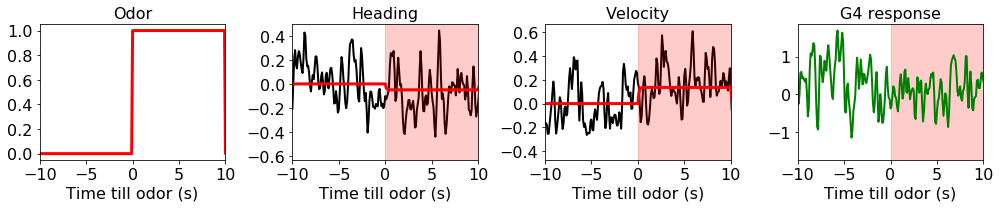

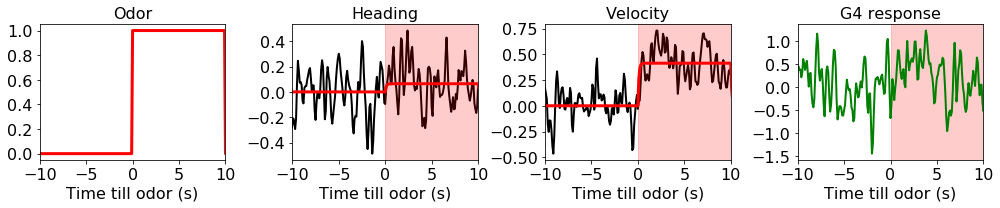

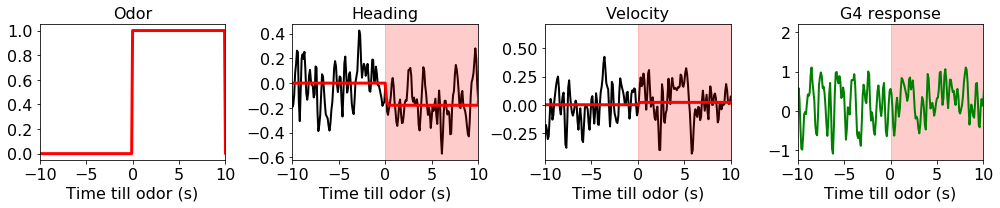

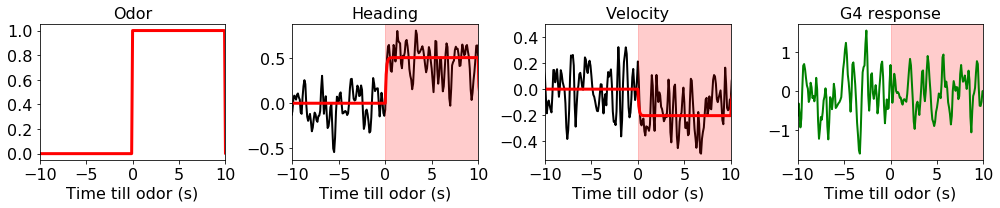

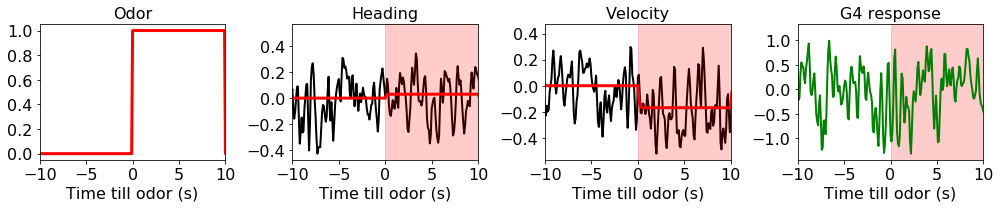

In [4]:
# plot filters
fig, axs = plt.subplots(1, 5, figsize=(15, 3), tight_layout=True)
axs[0].plot(t_f, h_o[::-1], lw=2, c='k')
axs[0].set_title('Odor -> Heading')
axs[1].plot(t_f, v_o[::-1], lw=2, c='k')
axs[1].set_title('Odor -> Velocity')
axs[2].plot(t_f, f_h[::-1], lw=2, c='k')
axs[2].set_title('Heading -> G4')
axs[3].plot(t_f, f_v[::-1], lw=2, c='k')
axs[3].set_title('Velocity -> G4')
axs[4].plot(t_f, f_o[::-1], lw=2, c='k')
axs[4].set_title('Odor -> G4')

print('H_ODOR WEIGHT =', w_h, '; V_ODOR WEIGHT =', w_v)

axs[0].set_ylabel('Filter strength')

for ax in axs:

    ax.set_xlabel('Relative time')
    set_font_size(ax, 16)
    ax.grid()
    
# example trials
for ctr in range(5):
    fig, axs = plt.subplots(1, 4, figsize=(14, 3), tight_layout=True)
    axs[0].plot(t, o, c='r', lw=3)
    axs[0].set_title('Odor')
    
    axs[1].plot(t, hs[ctr], c='k', lw=2, zorder=0)
    axs[1].plot(t, h_odors[ctr], c='r', lw=3, zorder=1)
    axs[1].set_title('Heading')
    
    axs[2].plot(t, vs[ctr], c='k', lw=2, zorder=0)
    axs[2].plot(t, v_odors[ctr], c='r', lw=3, zorder=1)
    axs[2].set_title('Velocity')
    
    axs[3].plot(t, gs[ctr], c='g', lw=2)
    axs[3].set_title('G4 response')
    
    for ax in axs[1:]:
        ax.axvspan(0, 10, color='r', alpha=.2)
        
    for ax in axs:
        ax.set_xlim(-10, 10)
        ax.set_xlabel('Time till odor (s)')
        set_font_size(ax, 16)

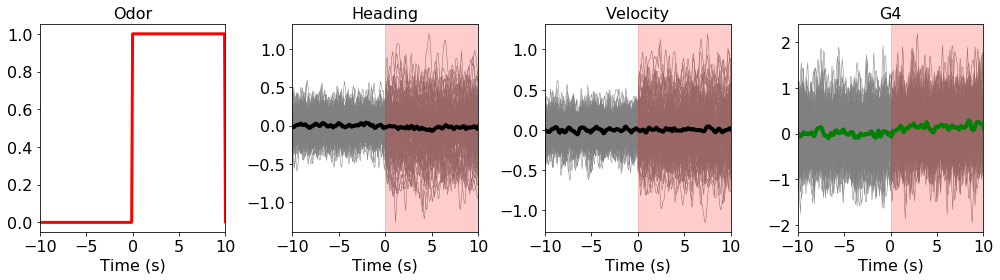

In [5]:
# odor-triggered averages
fig, axs = plt.subplots(1, 4, figsize=(14, 4), tight_layout=True)
axs[0].plot(t, o, c='r', lw=3)
axs[0].set_title('Odor')

axs[1].plot(t, hs.T, c='gray', lw=.5, zorder=0)
axs[1].plot(t, hs.mean(axis=0), c='k', lw=4, zorder=1)
axs[1].set_title('Heading')

axs[2].plot(t, vs.T, c='gray', lw=.5, zorder=0)
axs[2].plot(t, vs.mean(axis=0), c='k', lw=4, zorder=1)
axs[2].set_title('Velocity')

axs[3].plot(t, gs.T, c='gray', lw=.5, zorder=0)
axs[3].plot(t, gs.mean(axis=0), c='g', lw=4, zorder=1)
axs[3].set_title('G4')

for ax in axs[1:]:
    ax.axvspan(0, 10, color='r', alpha=.2)
for ax in axs:
    ax.set_xlim(-10, 10)
    ax.set_xlabel('Time (s)')
    set_font_size(ax, 16)

Analysis

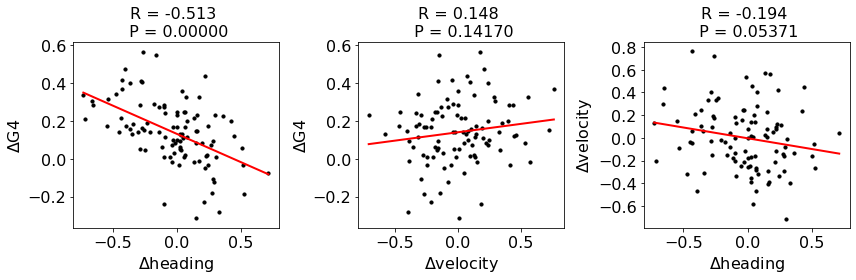

In [6]:
from scipy import stats

# calc corrs between time-avgd behav and neur activity
mt_pre = (-10 <= t) & (t < 0)
mt_dur = (0 <= t) & (t < 10)

delta_h = np.nan * np.zeros(N_TR)
delta_v = np.nan * np.zeros(N_TR)
delta_g = np.nan * np.zeros(N_TR)

for ctr in range(N_TR):
    delta_h[ctr] = hs[ctr][mt_dur].mean() - hs[ctr][mt_pre].mean()
    delta_v[ctr] = vs[ctr][mt_dur].mean() - vs[ctr][mt_pre].mean()
    delta_g[ctr] = gs[ctr][mt_dur].mean() - gs[ctr][mt_pre].mean()
    
slp_h_g, icpt_h_g, r_h_g, p_h_g = stats.linregress(delta_h, delta_g)[:4]
x_line_h_g = np.array([delta_h.min(), delta_h.max()])
y_line_h_g = slp_h_g*x_line_h_g + icpt_h_g

slp_v_g, icpt_v_g, r_v_g, p_v_g = stats.linregress(delta_v, delta_g)[:4]
x_line_v_g = np.array([delta_v.min(), delta_v.max()])
y_line_v_g = slp_v_g*x_line_v_g + icpt_v_g

slp_h_v, icpt_h_v, r_h_v, p_h_v = stats.linregress(delta_h, delta_v)[:4]
x_line_h_v = np.array([delta_h.min(), delta_h.max()])
y_line_h_v = slp_h_v*x_line_h_v + icpt_h_v
    
fig, axs = plt.subplots(1, 3, figsize=(12, 4), tight_layout=True)
axs[0].scatter(delta_h, delta_g, c='k', s=10)
axs[0].plot(x_line_h_g, y_line_h_g, c='r', lw=2)
axs[0].set_xlabel('$\Delta$heading')
axs[0].set_ylabel('$\Delta$G4')
axs[0].set_title(f'R = {r_h_g:.3f} \n P = {p_h_g:.5f}')

axs[1].scatter(delta_v, delta_g, c='k', s=10)
axs[1].plot(x_line_v_g, y_line_v_g, c='r', lw=2)
axs[1].set_xlabel('$\Delta$velocity')
axs[1].set_ylabel('$\Delta$G4')
axs[1].set_title(f'R = {r_v_g:.3f} \n P = {p_v_g:.5f}')

axs[2].scatter(delta_h, delta_v, c='k', s=10)
axs[2].plot(x_line_h_v, y_line_h_v, c='r', lw=2)
axs[2].set_xlabel('$\Delta$heading')
axs[2].set_ylabel('$\Delta$velocity')
axs[2].set_title(f'R = {r_h_v:.3f} \n P = {p_h_v:.5f}')

for ax in axs:
    set_font_size(ax, 16)